In [1]:
import sys
sys.path.insert(0,'/Users/jarad/fake_folder')

from jb_libraries import *
%matplotlib inline

* The RF Team was restructured on Jan 02, 2018. We want to know if the time to ship a package decreased after this event.
* We measure the time elapsed between when an order was set to processing and when it was set to shipped
* We treat partials like they are single orders
*****
* From AdaAccounts:

* The key moment it enters the queue is when an order is marked "processing". A lot of orders are placed and sit in the system until they are marked processing. 

* So stat should track time from processing>shipped, i believe.
*****
* We use the [t-test for equal means](http://www.itl.nist.gov/div898/handbook/eda/section3/eda353.htm)

# Get and clean data

In [2]:
# get all eligible reseller/super reseller OIDs
oids = pd.read_sql(
'''
SELECT
date_purchased AS 'purchased',
orders_id AS 'orders id'
FROM orders
WHERE (orders_reseller = 1 OR orders_super_reseller = 1)
AND YEAR(date_purchased) >= 2017
''', db)

In [3]:
partials_main = pd.read_sql(
'''
SELECT
psh_parent_id AS 'orders id',
psh_partial_id AS 'partial id',

CASE WHEN psh_partial_status_id = 2 THEN psh_date_added END AS 'processing',
CASE WHEN psh_partial_status_id = 3 AND psh_billing_id = 0 THEN psh_date_added END AS 'shipped'

FROM partial_status_history

WHERE psh_parent_id IN '''+ str(tuple(oids['orders id'])) +'''

AND psh_partial_status_id IN (2,3) # processing, shipped
''', db)

# we're not really getting max's, we're just making it so each orders_id/partial_id has only one
    # processing date (there are two in orders2)
partials = partials_main.groupby(['orders id','partial id'], as_index = False).agg({'processing':'max',
                                                                                    'shipped':'max'})
#===================================================================================================================

not_partials_main = pd.read_sql(
'''
SELECT
orders_id AS 'orders id',

CASE WHEN orders_status_id = 2 THEN date_added END AS 'processing',
CASE WHEN orders_status_id = 3 THEN date_added END AS 'shipped'

FROM orders_status_history
WHERE orders_id IN '''+ str(tuple(oids['orders id'])) +'''
AND orders_id NOT IN '''+ str(tuple(partials_main['orders id'])) +'''
AND orders_status_id IN (2,3) # processing, shipped
''', db)

not_partials = not_partials_main.groupby(['orders id'], as_index = False).agg({'processing':'max',
                                                                               'shipped':'max'})
# give non partials a fake partial of 1; this is for later
not_partials['partial id'] = 1

In [4]:
# concat partials and not-partials
orders_main = pd.concat([partials, not_partials])

# join to orders to get Date Purchased
orders = pd.merge(orders_main,
                  oids,
                  how = 'left',
                  on = 'orders id')

# organize columns
orders = orders[['orders id','partial id','purchased','processing','shipped']]

# only a few orders like this
# get rid of them
orders = orders[orders['processing'].isnull() == False]

# only consider orders that have been shipped
orders = orders[orders['shipped'].isnull() == False]

# produce a column of all unique values
orders['main oid'] = orders['orders id'].map(str) + '-' + orders['partial id'].map(str)

# get elapsed time in seconds
# dt.days returns a int of the # of days - it does not convert your time to days, so you have to get the seconds seperately
orders['elapsed in seconds'] = (((orders['shipped'] - orders['processing']).dt.days) * 86400) + (orders['shipped'] - orders['processing']).dt.seconds

#===================================================================================================================

if orders[orders['main oid'].duplicated()].empty:
    print('each line in your orders df is unique\n')
else:
    print('you have dupes in your orders df!\n')

print('count of unique OIDs in main OID query: {:,.0f}'.format(len(oids)))
print('count of unique OIDs in orders_main dataframe: {:,.0f}'.format(len(orders_main['orders id'].unique())))    
print('count of unique OIDs in orders dataframe after removing nulls: {:,.0f}'.format(len(orders['orders id'].unique())))  

each line in your orders df is unique

count of unique OIDs in main OID query: 8,955
count of unique OIDs in orders_main dataframe: 8,931
count of unique OIDs in orders dataframe after removing nulls: 8,808


# Analyze

In [5]:
# this is the demarcation date between "before" and "after"
after_start = '2018-01-02'

# get all orders after this demarcation date
after = orders.copy()
after = after[after['processing'] >= after_start]

# get count 
order_count = len(after)

# get order before demarcation date
# get the same number of orders as after
before = orders.copy()
before = before[before['processing'] < after_start].sort_values('processing', ascending = False).iloc[:order_count]

# now we have X number of orders "before" and X number of orders "after"
print('count of orders before: ', len(before))
print('count of orders after: ', order_count)
print('\n')
print('max date "before":', before['processing'].max().date())
print('min date "after":', after['processing'].min().date())

count of orders before:  698
count of orders after:  698


max date "before": 2018-01-01
min date "after": 2018-01-02


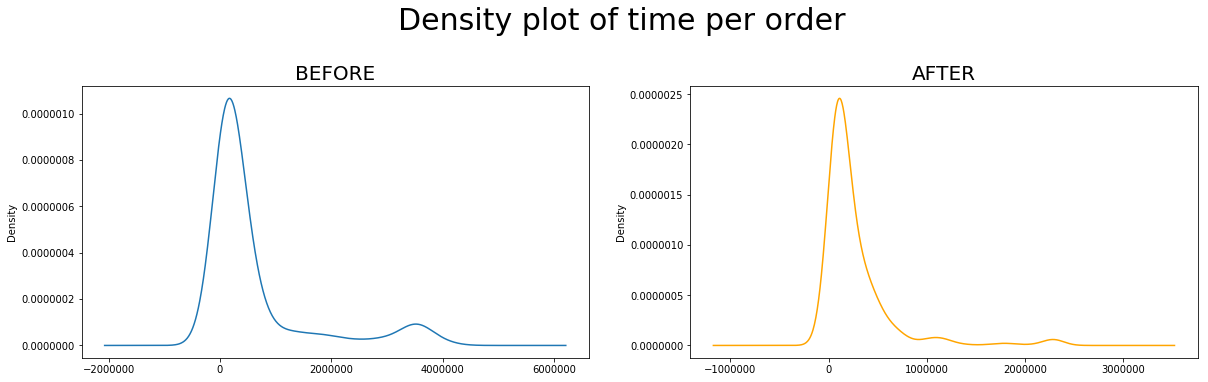

In [6]:
fig, axes = plt.subplots(1,2, figsize = (20,5))

before['elapsed in seconds'].plot(kind = 'density', ax = axes[0])
axes[0].set_title('BEFORE', fontsize = 20)

after['elapsed in seconds'].plot(kind = 'density', ax = axes[1], color = 'orange')
axes[1].set_title('AFTER', fontsize = 20,)

plt.suptitle('Density plot of time per order', fontsize = 30, y = 1.10)

plt.show()

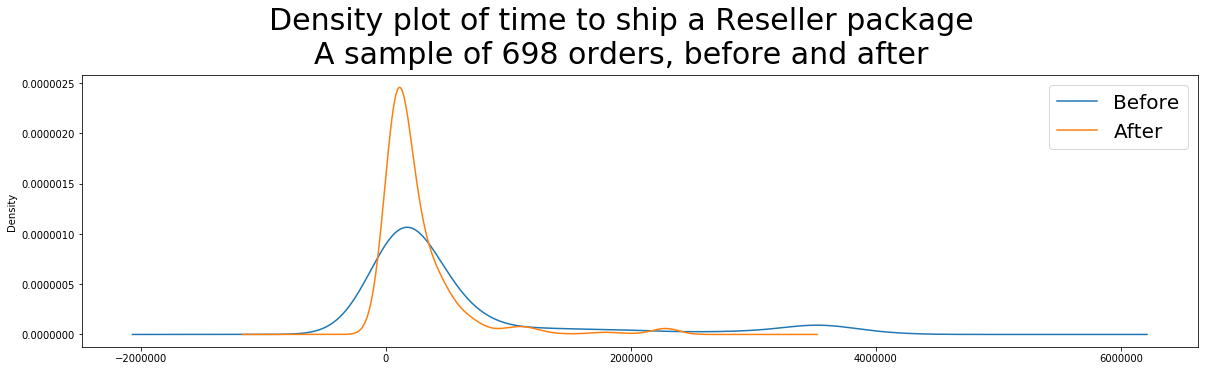

In [7]:
fig, ax = plt.subplots(figsize = (20,5))

before['elapsed in seconds'].plot(kind = 'density', ax = ax, label = 'Before')

after['elapsed in seconds'].plot(kind = 'density', ax = ax, label = 'After')

plt.suptitle('Density plot of time to ship a Reseller package\nA sample of {} orders, before and after'.format(len(after)), 
             fontsize = 30, 
             y = 1.07)
ax.legend(fontsize = 20)
plt.show()

### t test

* H0: before_mean = after_mean
* H1: before_mean != after_mean
* This is a two-sided test for the null hypothesis that 2 independent samples have identical averages
* If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.
****
* H0: before_mean = after_mean
* H1: before_mean > after_mean
****
[SciPy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

In [8]:
if np.abs(np.std(before['elapsed in seconds']) - np.std(after['elapsed in seconds'])) < 1.00:
    equal_var = True
    print('your variances are equal: ', equal_var)
else:
    equal_var = False
    print('your variances are equal: ', equal_var)

print('\n')    

test = stats.ttest_ind(before['elapsed in seconds'], after['elapsed in seconds'])
crit_value = stats.t.ppf(1 - 0.05, len(before) + len(after) - 2)
    
if test[1] <= 0.05:
    print('the means are not the same. there was a change\n')
else:
    print('the means are the same. there was no change\n')

print('your p value is: {:,.10f}'.format(test[1]))
print('your test stat is: {:,.10f}'.format(test[0]))
print('your rejection point is: {:,.5f}'.format(crit_value))

your variances are equal:  False


the means are not the same. there was a change

your p value is: 0.0000000000
your test stat is: 8.6072924693
your rejection point is: 1.64595


### Plot before and after

In [9]:
before_for_plot = before.copy()
before_for_plot = before_for_plot[['elapsed in seconds']]
before_for_plot['index'] = range(len(before_for_plot))
before_for_plot.set_index('index', inplace = True)
before_for_plot.rename(columns = {'elapsed in seconds':'before'}, inplace = True)

after_for_plot = after.copy()
after_for_plot = after_for_plot[['elapsed in seconds']]
after_for_plot['index'] = range(len(after_for_plot))
after_for_plot.set_index('index', inplace = True)
after_for_plot.rename(columns = {'elapsed in seconds':'after'}, inplace = True)

compare = pd.merge(before_for_plot, after_for_plot, left_index = True, right_index = True)

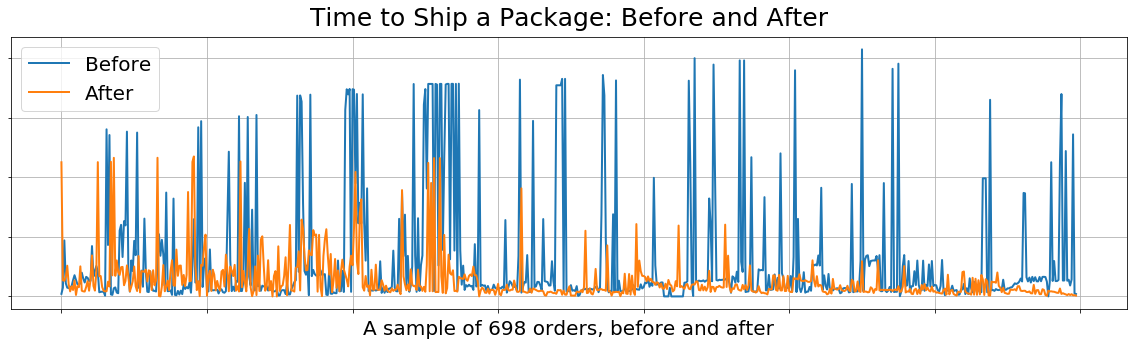

In [10]:
fig, ax = plt.subplots(figsize =(20,5))

compare.plot(ax = ax,
            lw = 2,
            label = ['Before','After'])
ax.set_title('Time to Ship a Package: Before and After', fontsize = 25, y = 1.02)
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.set_xlabel('A sample of {} orders, before and after'.format(len(after)),
             fontsize = 20)

ax.legend(['Before','After'], fontsize = 20)
ax.grid()
plt.show()

In [11]:
print('stats are in days')
# remember that we did this whole thing in seconds
# so convert back to days here
(compare.describe()/3600/24).loc['mean':].format_(['n2','n2'])

stats are in days


,Before,After
mean,7.10,3.11
std,11.46,4.30
min,0.01,0.01
25%,1.17,0.98
50%,2.16,1.53
75%,6.00,3.58
max,47.95,27.16
